In [8]:
import matplotlib.pyplot as plt
import numpy as np

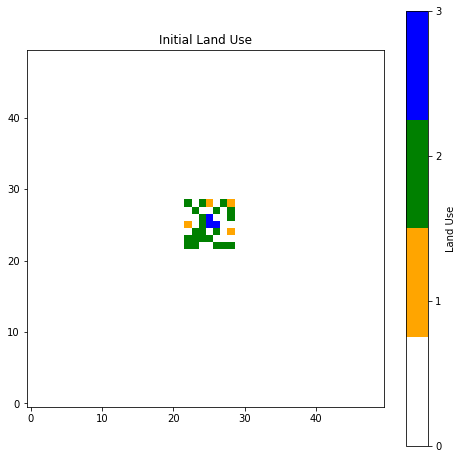

In [9]:
# Step 1: Define the grid and the states

# Define the grid size and the states
grid_size = 50
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial

# Initialize the grid with vacant cells
grid = np.full((grid_size, grid_size), states['V'])

# set seed to be 4263047662
np.random.seed(4)

# Set up the grid
grid_size = 50
grid = np.zeros((grid_size, grid_size), dtype=int)

# Define initial conditions
center_x, center_y = grid_size // 2, grid_size // 2
commercial_cells = [(center_x, center_y), (center_x + 1, center_y), (center_x, center_y + 1)]

residential_cells = []
num_residential = 30  # Number of residential cells
min_dist = 3  # Minimum distance from commercial cells

industrial_cells = []
num_industrial = 4  # Number of industrial cells
min_dist_industrial = 3  # Minimum distance from commercial cells

# Generate random residential cells around the commercial area
while len(residential_cells) < num_residential:
    x = np.random.randint(center_x - min_dist, center_x + min_dist + 1)
    y = np.random.randint(center_y - min_dist, center_y + min_dist + 1)
    if (x, y) not in commercial_cells:
        residential_cells.append((x, y))

# Generate random industrial cells around the commercial area
while len(industrial_cells) < num_industrial:
    x = np.random.randint(center_x - min_dist_industrial, center_x + min_dist_industrial + 1)
    y = np.random.randint(center_y - min_dist_industrial, center_y + min_dist_industrial + 1)
    if (x, y) not in commercial_cells:
        industrial_cells.append((x, y))

# Assign initial land use types
for x, y in commercial_cells:
    grid[x, y] = 3  # Commercial
for x, y in residential_cells:
    grid[x, y] = 2  # Residential
for x, y in industrial_cells:
    grid[x, y] = 1  # Industrial

# Set the figure size
fig = plt.figure(figsize=(8, 8))  # Adjust the width and height as desired

# Visualize the initial grid
cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'green', 'blue'])
plt.imshow(grid, cmap=cmap, origin='lower', vmin=0, vmax=3)
plt.colorbar(ticks=[0, 1, 2, 3], label='Land Use')
plt.title('Initial Land Use')

plt.show()



In [10]:
# Step 2: Define the exogenous growth rates and the initial number of cells to be converted

# Define the exogenous growth rates for each urban function
growth_rates = {'H': 1, 'I': 1, 'C': 1}  # H: housing, I: industrial, C: commercial

# Define the initial number of cells to be converted
initial_cells = {'H': 30, 'I': 4, 'C': 3}  # H: housing, I: industrial, C: commercial

# Initialize a dictionary to store the number of cells to be converted for each state in the previous iteration
previous_cells = initial_cells.copy()

# Function to calculate the net number of cells to be converted at each iteration
def calculate_cells_to_convert(iteration):
    cells_to_convert = {}
    for state in ['H', 'I', 'C']:
        if iteration == 0:
            # At the first iteration, use the initial number of cells to be converted
            cells_to_convert[state] = initial_cells[state]
        else:
            # In subsequent iterations, apply the growth rate to the number of cells converted in the previous iteration
            cells_to_convert[state] = int(previous_cells[state] * (1 + growth_rates[state]))
            # Update the number of cells to be converted for the current state in the previous iteration
            previous_cells[state] = cells_to_convert[state]
    return cells_to_convert

# Test the function
print('Cells to convert at iteration 0:', calculate_cells_to_convert(0))
print('Cells to convert at iteration 1:', calculate_cells_to_convert(1))

Cells to convert at iteration 0: {'H': 30, 'I': 4, 'C': 3}
Cells to convert at iteration 1: {'H': 60, 'I': 8, 'C': 6}


In [11]:
# Step 3: Define the neighbourhood of a cell and calculate the transition potentials

# Define the radius of the neighbourhood
radius = 6

# Function to get the neighbourhood of a cell
def get_neighbourhood(grid, row, col):
    # Define the range of the neighbourhood
    row_range = range(max(0, row - radius), min(grid_size, row + radius + 1))
    col_range = range(max(0, col - radius), min(grid_size, col + radius + 1))
    # Get the square neighbourhood
    square_neighbourhood = grid[np.ix_(row_range, col_range)]
    # Create a mask for the circular neighbourhood
    circle_mask = np.zeros_like(square_neighbourhood, dtype=bool)
    center = radius, radius  # The center of the circle is the cell itself
    for i in range(square_neighbourhood.shape[0]):
        for j in range(square_neighbourhood.shape[1]):
            # If the Euclidean distance from the center to the cell is less than or equal to the radius, include the cell in the circle
            if np.sqrt((center[0] - i) ** 2 + (center[1] - j) ** 2) <= radius:
                circle_mask[i, j] = True
    # Return the circular neighbourhood
    return square_neighbourhood[circle_mask]

# Test the function
print('Neighbourhood of the cell at (25, 25):\n', get_neighbourhood(grid, 25, 25))
print('The number of Neighborss of the cell at the center is ', len(get_neighbourhood(grid, 25, 25)))

Neighbourhood of the cell at (25, 25):
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 2 2 2 0 0 0 0 2 2 2 2 0 0 0
 0 0 0 0 0 2 2 0 2 0 1 0 0 0 0 0 1 0 2 3 3 0 0 0 0 0 0 0 0 0 2 3 0 0 2 0 0
 0 0 0 2 0 0 2 0 2 0 0 0 0 2 0 2 1 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
The number of Neighborss of the cell at the center is  113


In [12]:
m_kd = {
    'V': {
        2: {'C': 25, 'I': 0, 'H': 4},
        3: {'C': 25, 'I': 0, 'H': 3.5},
        4: {'C': 25, 'I': 0, 'H': 3},
        5: {'C': -1, 'I': 0, 'H': 2.5},
        6: {'C': -1, 'I': 0, 'H': 2},
        7: {'C': -1, 'I': 0, 'H': 2},
        8: {'C': -1, 'I': 0, 'H': 2},
        9: {'C': -1, 'I': 0, 'H': 1.5},
        10: {'C': -1, 'I': 0, 'H': 1.5},
        11: {'C': -1, 'I': 0, 'H': 1.5},
        12: {'C': -1, 'I': 0, 'H': 1.5},
        13: {'C': -1, 'I': 0, 'H': 1},
        14: {'C': -1, 'I': 0, 'H': 1},
        15: {'C': -1, 'I': 0, 'H': 1},
        16: {'C': -1, 'I': 0, 'H': 1},
        17: {'C': -1, 'I': 0, 'H': 1},
        18: {'C': -1, 'I': 0, 'H': 1},
        19: {'C': -1, 'I': 0, 'H': 1}
    },
    'C': {
        2: {'C': 25, 'I': -2, 'H': 4},
        3: {'C': 25, 'I': -2, 'H': 3.5},
        4: {'C': 25, 'I': -2, 'H': 3},
        5: {'C': -2, 'I': 0, 'H': 2.5},
        6: {'C': -2, 'I': 0, 'H': 2},
        7: {'C': -2, 'I': 0, 'H': 2},
        8: {'C': -2, 'I': 0, 'H': 1.5},
        9: {'C': -2, 'I': 0, 'H': 1.5},
        10: {'C': -2, 'I': 0, 'H': 1.5},
        11: {'C': -2, 'I': 0, 'H': 1.5},
        12: {'C': -2, 'I': 0, 'H': 1},
        13: {'C': -2, 'I': 0, 'H': 1},
        14: {'C': -2, 'I': 0, 'H': 1},
        15: {'C': -2, 'I': 0, 'H': 1},
        16: {'C': -2, 'I': 0, 'H': 1},
        17: {'C': -2, 'I': 0, 'H': 1},
        18: {'C': -2, 'I': 0, 'H': 1},
        19: {'C': -2, 'I': 0, 'H': 1}
    },
    'I': {
        2: {'C': 0, 'I': 0, 'H': 3},
        3: {'C': 0, 'I': 0, 'H': 3},
        4: {'C': 0, 'I': 0, 'H': 2},
        5: {'C': 0, 'I': 0, 'H': 1},
        6: {'C': 0, 'I': 0, 'H': 0},
        7: {'C': 0, 'I': 0, 'H': 0.2},
        8: {'C': 0, 'I': 0.2, 'H': 20.2},
        9: {'C': 0, 'I': 0.2, 'H': 20.2},
        10: {'C': 0, 'I': 0.2, 'H': 0.2},
        11: {'C': 0, 'I': 0.2, 'H': 0.2},
        12: {'C': 0, 'I': 0.2, 'H': 0.2},
        13: {'C': 0, 'I': 0.2, 'H': 0.2},
        14: {'C': 0, 'I': 0.2, 'H': 0.2},
        15: {'C': 0, 'I': 0.2, 'H': 20.2},
        16: {'C': 0, 'I': 0.2, 'H': 0.2},
        17: {'C': 0, 'I': 0.2, 'H': 0.2},
        18: {'C': 0, 'I': 0.2, 'H': 0.2},
        19: {'C': 0, 'I': 0.2, 'H': 0.2}
    },
    'H': {
        2: {'C': -2, 'I': 1, 'H': 0},
        3: {'C': -1, 'I': 1, 'H': 0},
        4: {'C': 2, 'I': 0, 'H': 0},
        5: {'C': 1, 'I': 0, 'H': 0},
        6: {'C': 1, 'I': 0, 'H': 0},
        7: {'C': 1, 'I': 0, 'H': 0},
        8: {'C': 0.5, 'I': 0, 'H': 0},
        9: {'C': 0.5, 'I': 0, 'H': 0},
        10: {'C': 0.5, 'I': 0, 'H': 0},
        11: {'C': 0.5, 'I': 0, 'H': 0},
        12: {'C': 0.5, 'I': 0, 'H': 0},
        13: {'C': 0.1, 'I': 0, 'H': 0},
        14: {'C': 0.1, 'I': 0, 'H': 0},
        15: {'C': 0.1, 'I': 0, 'H': 0},
        16: {'C': 0.1, 'I': 0, 'H': 0},
        17: {'C': 0.1, 'I': 0, 'H': 0},
        18: {'C': 0.1, 'I': 0, 'H': 0},
        19: {'C': 0, 'I': 0, 'H': 0}
    }
}


In [13]:

def get_cells_in_distance_zone(grid, row, col, d):
    # Calculate the Euclidean distance from the cell to all other cells
    distances = np.sqrt((np.indices(grid.shape)[0] - row) ** 2 + (np.indices(grid.shape)[1] - col) ** 2)
    # Return the cells in the distance zone
    return grid[(distances >= d) & (distances < d + 1)]

def calculate_transition_potential(grid, row, col):
    # Calculate the transition potential for each possible transition
    transition_potentials = {}
    for transition, weights in m_kd.items():
        # Initialize the weighted sum for the transition
        weighted_sum = 0
        # Iterate over all distance zones
        for d, distance_weights in weights.items():
            # Get the cells in the distance zone
            zone_cells = get_cells_in_distance_zone(grid, row, col, d)
            # Iterate over all states
            for state, state_weight in distance_weights.items():
                # Count the number of cells in the state in the distance zone
                N_kd = np.sum(zone_cells == state)
                # Add the weighted count to the weighted sum
                weighted_sum += state_weight * N_kd

        # Calculate the stochastic disturbance term
        R = np.random.uniform(0, 1)
        alpha = 1  # This parameter allows control of the size of the stochastic perturbation
        S = 1 + (-np.log(R)) ** alpha
        # Calculate the transition potential
        P_ij = S * (1 + weighted_sum)
        transition_potentials[transition] = P_ij

    return transition_potentials






/var/folders/z4/tp6kp7y165g0bvx3x1wrblq00000gn/T/ipykernel_33663/2269967639.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  N_kd = np.sum(zone_cells == state)


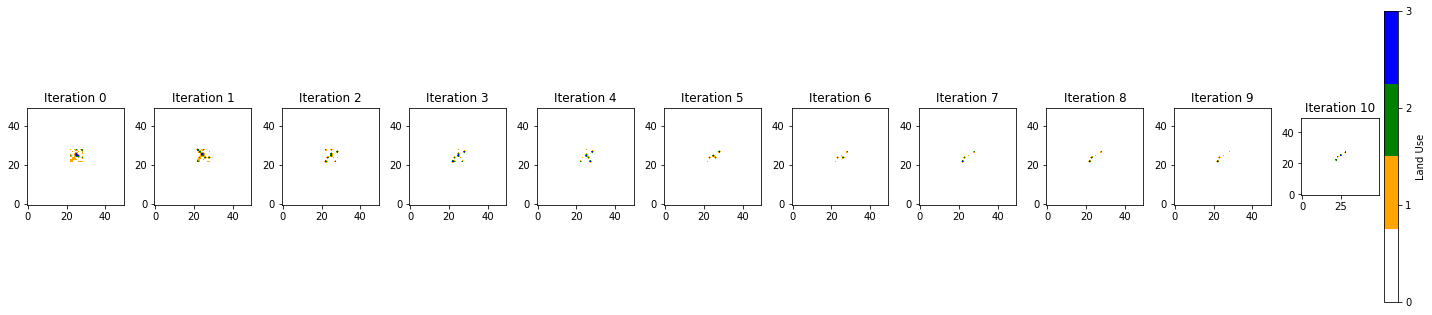

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define the grid size and the states
grid_size = 50
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial

# Initialize the grid with vacant cells
grid = np.full((grid_size, grid_size), states['V'])

# Set up the initial land use configuration
# Step 1: Define the grid and the states

# Define the grid size and the states
grid_size = 50
states = {'V': 0, 'H': 1, 'I': 2, 'C': 3}  # V: vacant, H: housing, I: industrial, C: commercial

# Initialize the grid with vacant cells
grid = np.full((grid_size, grid_size), states['V'])

# Set the seed for reproducibility
np.random.seed(4)

# Set up the grid
grid_size = 50
grid = np.zeros((grid_size, grid_size), dtype=int)

# Define initial conditions
center_x, center_y = grid_size // 2, grid_size // 2
commercial_cells = [(center_x, center_y), (center_x + 1, center_y), (center_x, center_y + 1)]

residential_cells = []
num_residential = 30  # Number of residential cells
min_dist = 3  # Minimum distance from commercial cells

industrial_cells = []
num_industrial = 4  # Number of industrial cells
min_dist_industrial = 3  # Minimum distance from commercial cells

# Generate random residential cells around the commercial area
while len(residential_cells) < num_residential:
    x = np.random.randint(center_x - min_dist, center_x + min_dist + 1)
    y = np.random.randint(center_y - min_dist, center_y + min_dist + 1)
    if (x, y) not in commercial_cells:
        residential_cells.append((x, y))

# Generate random industrial cells around the commercial area
while len(industrial_cells) < num_industrial:
    x = np.random.randint(center_x - min_dist_industrial, center_x + min_dist_industrial + 1)
    y = np.random.randint(center_y - min_dist_industrial, center_y + min_dist_industrial + 1)
    if (x, y) not in commercial_cells:
        industrial_cells.append((x, y))

# Assign initial land use types
for x, y in commercial_cells:
    grid[x, y] = states['C']  # Commercial
for x, y in residential_cells:
    grid[x, y] = states['H']  # Residential
for x, y in industrial_cells:
    grid[x, y] = states['I']  # Industrial

# Set the number of iterations for the simulation
num_iterations = 10

# Create a list to store the grid at each iteration
grid_history = [grid.copy()]

# Perform the simulation
for iteration in range(num_iterations):
    # Calculate the net number of cells to be converted in the current iteration
    cells_to_convert = calculate_cells_to_convert(iteration)

    # Iterate over each cell in the grid
    for row in range(grid_size):
        for col in range(grid_size):
            current_state = grid[row, col]

            # Skip vacant cells
            if current_state == states['V']:
                continue

            # Calculate the transition potentials for the current cell
            transition_potentials = calculate_transition_potential(grid, row, col)

            # Normalize the transition probabilities to ensure they sum up to 1
            transition_probabilities = np.array(list(transition_potentials.values()))
            transition_probabilities /= transition_probabilities.sum()

            # Perform a weighted random choice based on the transition probabilities
            transitions = list(transition_potentials.keys())
            chosen_transition = np.random.choice(transitions, p=transition_probabilities)

            # Convert the cell to the new state based on the chosen transition
            new_state = states[chosen_transition]
            grid[row, col] = new_state

    # Append the current grid to the grid history
    grid_history.append(grid.copy())

# Visualize the land use evolution over time
fig, axes = plt.subplots(1, num_iterations + 1, figsize=(20, 5), tight_layout=True)

cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'green', 'blue'])

# Plot the initial land use
axes[0].imshow(grid_history[0], cmap=cmap, origin='lower', vmin=0, vmax=3)
axes[0].set_title('Iteration 0')

# Plot the land use at each iteration
for i in range(1, num_iterations + 1):
    axes[i].imshow(grid_history[i], cmap=cmap, origin='lower', vmin=0, vmax=3)
    axes[i].set_title(f'Iteration {i}')

# Add a colorbar to the last plot
cbar = plt.colorbar(axes[-1].imshow(grid_history[-1], cmap=cmap, origin='lower', vmin=0, vmax=3), ax=axes[-1])
cbar.set_ticks([0, 1, 2, 3])
cbar.set_label('Land Use')

plt.show()
